In [1]:
import pandas
import datetime
import feather
import numpy
import scipy.optimize
from aacgmv2 import convert_mlt
import seaborn as sns
from davitpy import utils
from imagers.ssusi import ssusi_utils
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter
%matplotlib inline

In [2]:
# Some constants
eventDate = datetime.datetime(2016,7,25)
timeStart = datetime.datetime(2016,7,25,3,0)
timeEnd = datetime.datetime(2016,7,25,7,0)
sapsTime = datetime.datetime(2016,7,25,5,50)
tecScale = [ 0, 15 ]
trghLatRange = [ 50, 65 ]

In [3]:
# read TEC data from the feather file
tecDF = feather.read_dataframe('../data/tec-mf-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
tecDF.head()

,dateStr,timeStr,Mlat,Mlon,med_tec,dlat,dlon,date,MLT
0,20160725,200,11.0,0.0,3.1,1.0,2.0,2016-07-25 02:00:00,21.165544
1,20160725,200,11.0,2.0,2.7,1.0,2.0,2016-07-25 02:00:00,21.298877
2,20160725,200,11.0,4.0,2.3,1.0,2.0,2016-07-25 02:00:00,21.432210
3,20160725,200,11.0,6.0,2.7,1.0,2.0,2016-07-25 02:00:00,21.565544
4,20160725,200,11.0,8.0,2.7,1.0,2.0,2016-07-25 02:00:00,21.698877


In [4]:
# Get the min loc of trough at diff MLONs
trghLocsDF = tecDF[ (tecDF["med_tec"] <= 20.) &\
                  (tecDF["Mlat"] >= trghLatRange[0]) &\
                  (tecDF["Mlat"] <= trghLatRange[1]) ]
trghLocsDF["time"] = [ date2num(x) for x in trghLocsDF["date"] ]
trghMinDF = trghLocsDF[ ["time", "Mlon", "med_tec"]\
                 ].groupby( [ "time", "Mlon" ]\
                ).min().reset_index()
trghMinDF["Mlon2"] = [x-360 if x>180 else x for x in trghMinDF["Mlon"] ]
trghMinDF.head()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,time,Mlon,med_tec,Mlon2
0,736170.083333,0.0,5.2,0.0
1,736170.083333,2.0,4.9,2.0
2,736170.083333,4.0,4.4,4.0
3,736170.083333,6.0,3.8,6.0
4,736170.083333,8.0,3.7,8.0


In [5]:
trghMlatDF = pandas.merge( trghLocsDF[ ["time", "Mlon", "Mlat",\
                            "date", "med_tec"] ],\
                          trghMinDF,\
                          on=["time", "Mlon", "med_tec"] )
# drop duplicates
trghMlatDF = trghMlatDF.drop_duplicates(\
                    subset=["time", "Mlon",  "Mlon2"], keep="first")
trghMlatDF.head()

,time,Mlon,Mlat,date,med_tec,Mlon2
0,736170.083333,60.0,50.0,2016-07-25 02:00:00,3.4,60.0
2,736170.083333,76.0,50.0,2016-07-25 02:00:00,1.8,76.0
3,736170.083333,102.0,50.0,2016-07-25 02:00:00,4.1,102.0
6,736170.083333,104.0,50.0,2016-07-25 02:00:00,3.5,104.0
7,736170.083333,106.0,50.0,2016-07-25 02:00:00,3.6,106.0


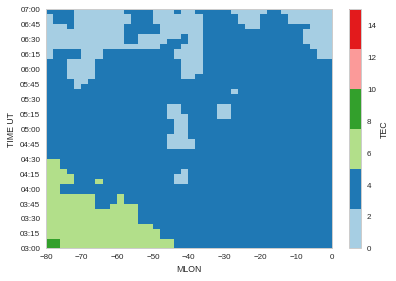

In [6]:
# Make an RTIish Plot
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Paired"))
# xticks
# set a few standard xticks
xTickList = []
currTime = timeStart
while currTime <= timeEnd:
    xTickList.append( currTime )
    currTime += datetime.timedelta(minutes=15)
# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
plotDF = trghMinDF[ ["time", "Mlon2",\
                        "med_tec"] ].pivot( "time", "Mlon2" )

timeVals = plotDF.index.values
mlonVals = plotDF.columns.levels[1].values

timeCntr, mlonCntr  = numpy.meshgrid( timeVals, mlonVals )
# Mask the nan values! pcolormesh can't handle them well!
tecVals = numpy.ma.masked_where(\
                numpy.isnan(plotDF["med_tec"].values),\
                plotDF["med_tec"].values)
rtiPlot = ax.pcolormesh(mlonCntr.T , timeCntr.T, tecVals,\
                        cmap=seaMap, vmin=tecScale[0],vmax=tecScale[1])

ax.set_ylim( [ timeStart, timeEnd ] )
ax.set_xlim( [ -80, 0 ] )
ax.set_ylabel("TIME UT")
ax.set_xlabel("MLON")
ax.get_yaxis().set_major_formatter(DateFormatter('%H:%M'))

ax.set_yticks(xTickList)

cbar = plt.colorbar(rtiPlot, orientation='vertical')
cbar.set_label("TEC")

fig.savefig("../plots/tec-" +\
            sapsTime.strftime("%Y%m%d") +\
            ".pdf" ,bbox_inches='tight')

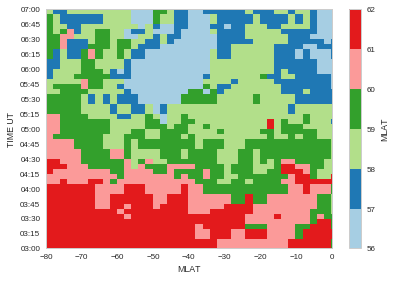

In [7]:
# Make an RTIish Plot
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Paired"))
# xticks
# set a few standard xticks
xTickList = []
currTime = timeStart
while currTime <= timeEnd:
    xTickList.append( currTime )
    currTime += datetime.timedelta(minutes=15)
# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
plotDF = trghMlatDF[ ["time", "Mlon2",\
                        "Mlat"] \
                   ].pivot( "time", "Mlon2" )

timeVals = plotDF.index.values
mlonVals = plotDF.columns.levels[1].values

timeCntr, mlonCntr  = numpy.meshgrid( timeVals, mlonVals )
# Mask the nan values! pcolormesh can't handle them well!
mlatVals = numpy.ma.masked_where(numpy.isnan(\
                plotDF["Mlat"].values), plotDF["Mlat"].values)
rtiPlot = ax.pcolormesh(mlonCntr.T , timeCntr.T, mlatVals,\
                        cmap=seaMap, vmin=56., vmax=62.)

ax.set_ylim( [ timeStart, timeEnd ] )
ax.set_xlim( [ -80, 0 ] )
ax.set_ylabel("TIME UT")
ax.set_xlabel("MLAT")
ax.get_yaxis().set_major_formatter(DateFormatter('%H:%M'))

ax.set_yticks(xTickList)

cbar = plt.colorbar(rtiPlot, orientation='vertical')
cbar.set_label("MLAT")

fig.savefig("../plots/tec-lats-" +\
            sapsTime.strftime("%Y%m%d") +\
            ".pdf" ,bbox_inches='tight')